# Load the raw data

In [139]:
import pandas as pd 
import os
import numpy as np
import plotly.graph_objects as go
import plotly
import plotly.express as px
import plotly.io as pio
from IPython.display import Image

# Load data
print('Beginning data loading ...')

# Data directory
dir_parent = os.path.dirname(os.getcwd())
dir_data = os.path.join(dir_parent, 'COVID-19/csse_covid_19_data/csse_covid_19_time_series')

# US case 
dir_US = os.path.join(dir_data, 'time_series_covid19_confirmed_us.csv')
US_case = pd.read_csv(dir_US)

# US death
dir_US_death = os.path.join(dir_data, 'time_series_covid19_deaths_US.csv')
US_death = pd.read_csv(dir_US_death)

# US state code
dir_US_state_abbreviation = os.path.join(os.getcwd(), 'data', 'US_state_abbreviation.csv')
US_state_abbreviation = pd.read_csv(dir_US_state_abbreviation)

print('Data loading finished!')


Beginning data loading ...
Data loading finished!


# Explore and analyze confirmed cases

## Clean up the data

In [140]:
# Drop unimportant columns
US_case.drop(columns=['UID', 'iso2', 'iso3','code3', 'Combined_Key', 'Country_Region'], inplace=True)

# Drop states associated with cruise ships
US_case.drop(US_case.index[US_case.Province_State.isin(['Diamond Princess', 'Grand Princess'])], inplace=True)

# Rename county column
US_case.rename(columns={'Admin2': 'County'}, inplace=True)

In [141]:
US_case.head(2)

,FIPS,County,Province_State,Lat,Long_,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,...,5/2/20,5/3/20,5/4/20,5/5/20,5/6/20,5/7/20,5/8/20,5/9/20,5/10/20,5/11/20
0,60.0,NaN,American Samoa,-14.2710,-170.1320,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,66.0,NaN,Guam,13.4443,144.7937,0,0,0,0,0,...,145,145,145,145,149,149,151,151,151,151


In [142]:
# Collapse across states
# We want to take the mean across lat and long columns
# and sum across the case columns.
dict_transform = {}
feature_column = US_case.keys()[3:]
for column in feature_column:
    if column in ['Lat', 'Long_']:
        dict_transform[column] = 'mean'
    else:
        dict_transform[column] = 'sum'
        
US_state_case = US_case.groupby('Province_State').agg(dict_transform).reset_index()

In [143]:
US_state_case.head(10)

,Province_State,Lat,Long_,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,...,5/2/20,5/3/20,5/4/20,5/5/20,5/6/20,5/7/20,5/8/20,5/9/20,5/10/20,5/11/20
0,Alabama,31.931113,-84.196785,0,0,0,0,0,0,0,...,7611,7888,8112,8437,8691,9046,9385,9668,9889,10164
1,Alaska,56.373544,-136.429656,0,0,0,0,0,0,0,...,365,368,370,371,372,374,377,378,379,379
2,American Samoa,-14.271000,-170.132000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Arizona,29.714033,-98.349911,0,0,0,0,1,1,1,...,8364,8640,8924,9305,9707,9945,10526,10960,11119,11383
4,Arkansas,34.005087,-90.033096,0,0,0,0,0,0,0,...,3372,3437,3491,3525,3611,3703,3747,3747,4012,4043
5,California,36.582496,-116.704308,0,0,0,0,2,2,2,...,53347,54903,55884,58456,60616,62148,63779,66558,67600,69329
6,Colorado,37.755612,-102.289687,0,0,0,0,0,0,0,...,16225,16635,16918,17367,17832,18370,18827,19375,19703,19879
7,Connecticut,33.290944,-58.125464,0,0,0,0,0,0,0,...,29287,29287,29973,30621,30995,31784,32411,32984,33554,33765
8,Delaware,23.465566,-45.319942,0,0,0,0,0,0,0,...,5038,5208,5288,5371,5778,5939,6111,6277,6277,6565
9,District of Columbia,12.968059,-25.672187,0,0,0,0,0,0,0,...,4797,5016,5170,5322,5461,5654,5899,6102,6272,6389


In [145]:
# Merge the state code table (for plotting chloropeth map)
US_state_case = US_state_abbreviation.merge(US_state_case, left_on='State', right_on='Province_State', how='outer')
US_state_case.drop(columns=['State'], inplace=True)

## Look at top-15 states with the most number of cases

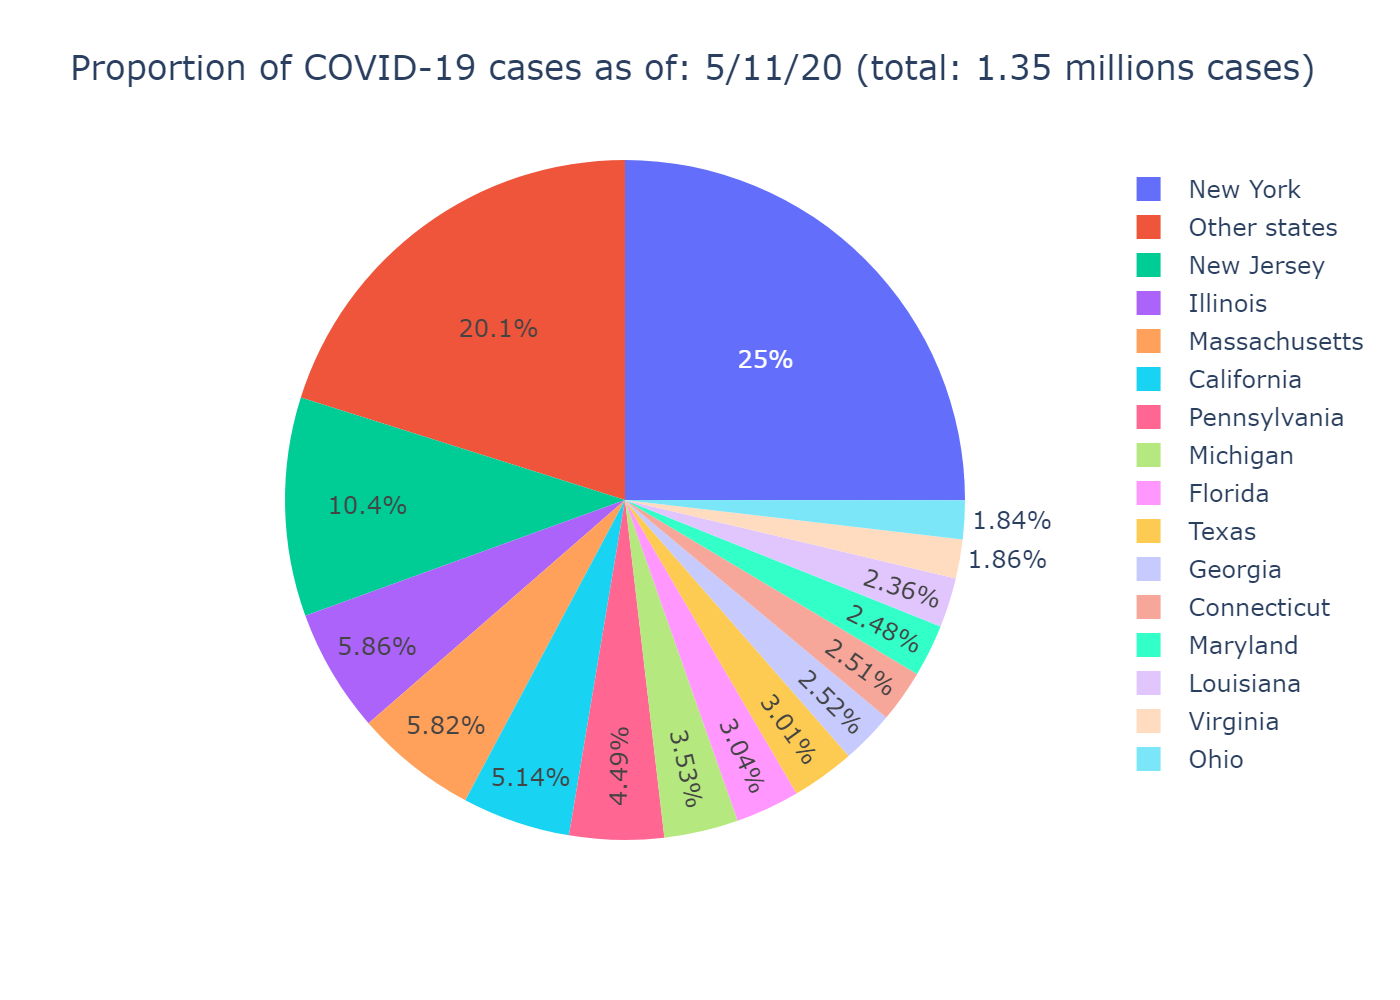

In [146]:
# Select top-15 states and aggregate all other countries
date_string = feature_column[2:]
total_case = round(US_state_case[date_string[-1]].sum() / 1000000, 2)
top_state = US_state_case.nlargest(15, date_string[-1])
state_collapse_bottom = US_state_case.copy()
state_collapse_bottom.loc[state_collapse_bottom[date_string[-1]] < top_state[date_string[-1]].min(),
                            'Province_State'] = 'Other states'


# Pie chart
fig = px.pie(state_collapse_bottom, values=date_string[-1], names='Province_State',
             title='Proportion of COVID-19 cases as of: ' + date_string[-1] + " (total: " + str(total_case) + " millions cases)")

margin_size = 80
fig.update_layout(margin=dict(l=margin_size, r=margin_size, t=margin_size, b=margin_size))

# Interactive plot
# fig.show()

# Static plot (to show the figures on Github, I have to convert to static image)
# For interactive plot, use the interactive plot above
Image(pio.to_image(fig, format='png', scale=2))

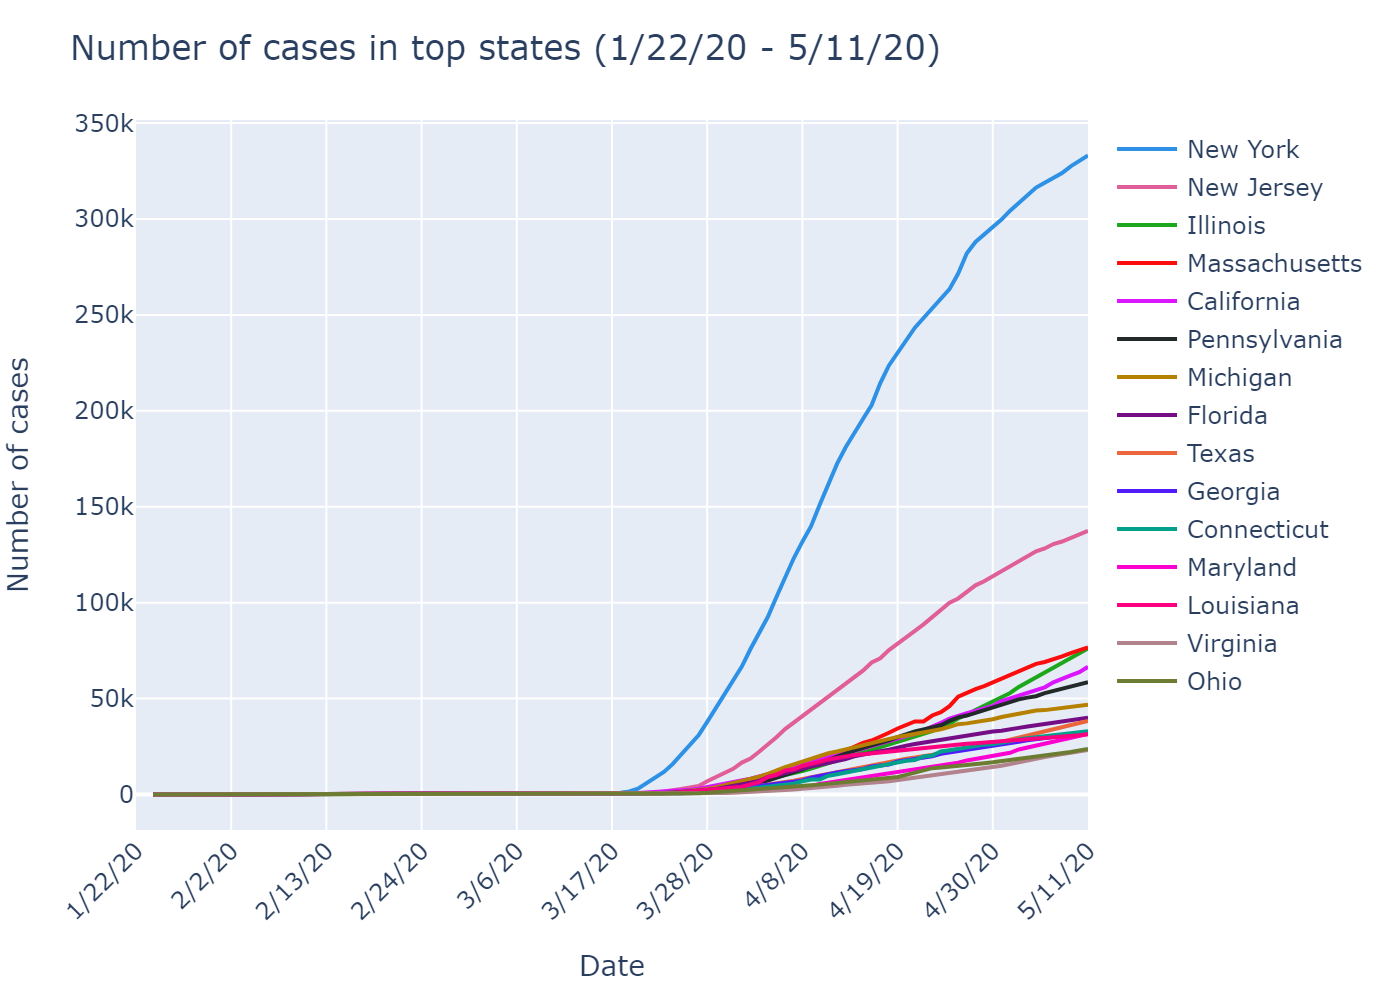

In [147]:
# Now let's look at the number of case across time
name_top_state = top_state['Province_State']
matrix_num_case = top_state.drop(columns=['Province_State', 'Lat', 'Long_']).to_numpy()

# Plot the number of cases
fig = go.Figure()
color_values = plotly.colors.qualitative.Dark24
for index, country in enumerate(name_top_state):
    fig.add_trace(go.Scatter(x=date_string, y=matrix_num_case[index, :], name=country,
                             line=dict(color=color_values[index])))
    
margin_size = 60
fig.update_layout(title='Number of cases in top states (' + date_string[0] + ' - ' + date_string[-1] + ')',
                   xaxis_title='Date',
                   yaxis_title='Number of cases',
                 margin=dict(l=margin_size, r=margin_size, t=margin_size, b=margin_size), height=500)
fig.update_xaxes(tickangle=-45, nticks=10)

# Interactive plot
# fig.show()

# Static plot (for view on Github)
Image(pio.to_image(fig, format='png', scale=2))

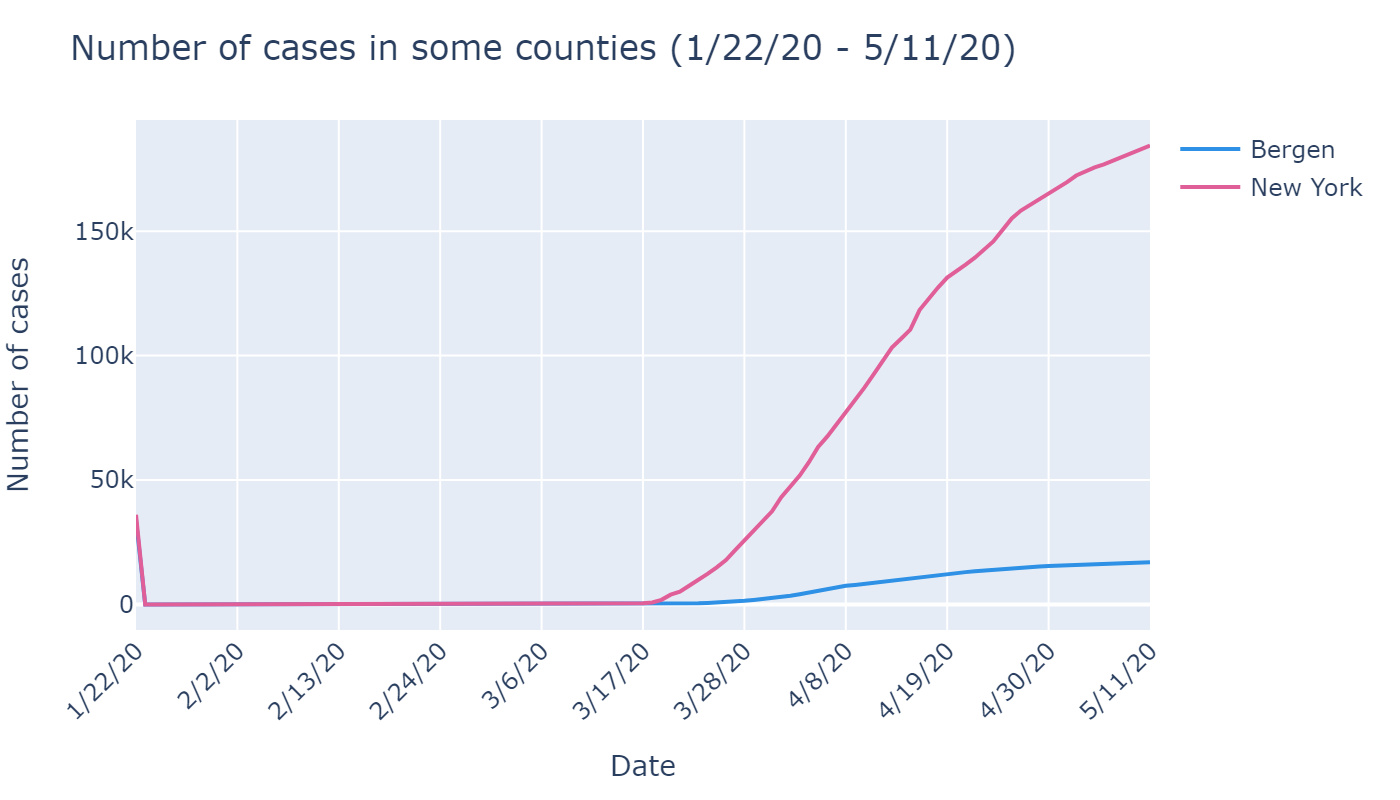

In [148]:
# Look at some cities I'm interested in
county_interest = US_case[US_case.County.isin(['New York', 'Bergen']) 
                          & US_case.Province_State.isin(['New York', 'New Jersey'])]
county_interest_name = county_interest['County']

# Now let's look at the number of case across time
matrix_num_case = county_interest.drop(columns=['County', 'Province_State', 'Lat', 'Long_']).to_numpy()

# Plot the number of cases
fig = go.Figure()
color_values = plotly.colors.qualitative.Dark24
for index, country in enumerate(county_interest_name):
    fig.add_trace(go.Scatter(x=date_string, y=matrix_num_case[index, :], name=country,
                             line=dict(color=color_values[index])))
    
margin_size = 60
fig.update_layout(title='Number of cases in some counties (' + date_string[0] + ' - ' + date_string[-1] + ')',
                   xaxis_title='Date',
                   yaxis_title='Number of cases',
                 margin=dict(l=margin_size, r=margin_size, t=margin_size, b=margin_size), height=400)
fig.update_xaxes(tickangle=-45, nticks=10)

# Interactive plot
# fig.show()

# Static plot (for view on Github)
Image(pio.to_image(fig, format='png', scale=2))

## Look at bottom-15 states with the least number of cases

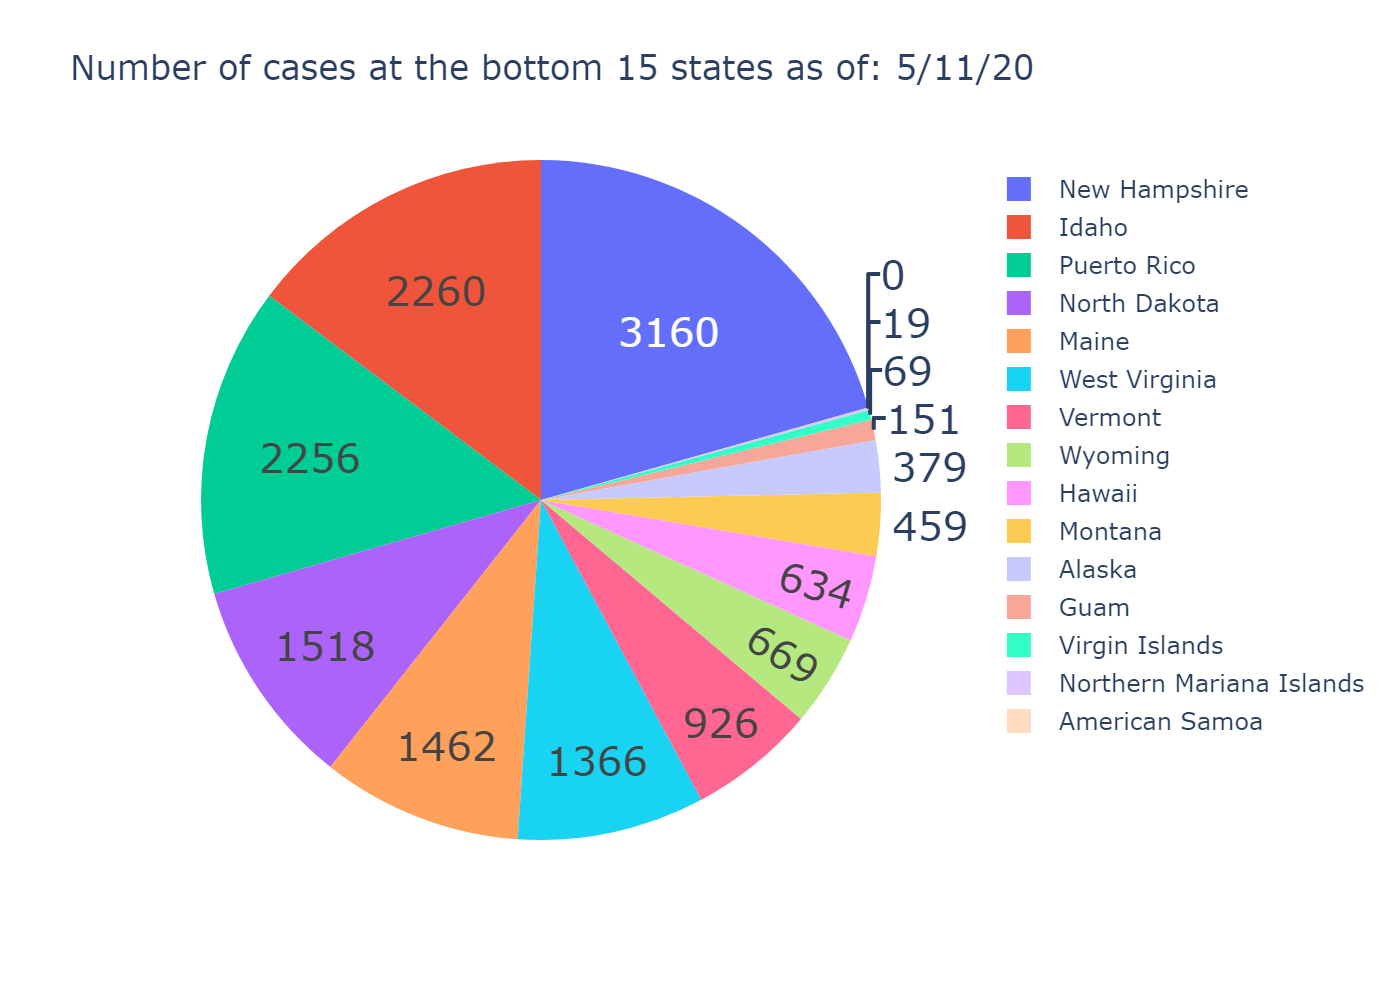

In [149]:
# Display the states with the least number of cases
bottom_state = US_state_case.nsmallest(15, date_string[-1])

fig = go.Figure(data=[go.Pie(labels=bottom_state['Province_State'],
                             values=bottom_state[date_string[-1]])])

margin_size = 80
fig.update_traces(hoverinfo='label+value', textinfo='value', textfont_size=20)
fig.update_layout(margin=dict(l=margin_size-20, r=margin_size-20, t=margin_size, b=margin_size),
                 title_text='Number of cases at the bottom 15 states as of: ' + date_string[-1])

# Interactive plot
# fig.show()

# Static plot (for view on Github)
Image(pio.to_image(fig, format='png', scale=2))

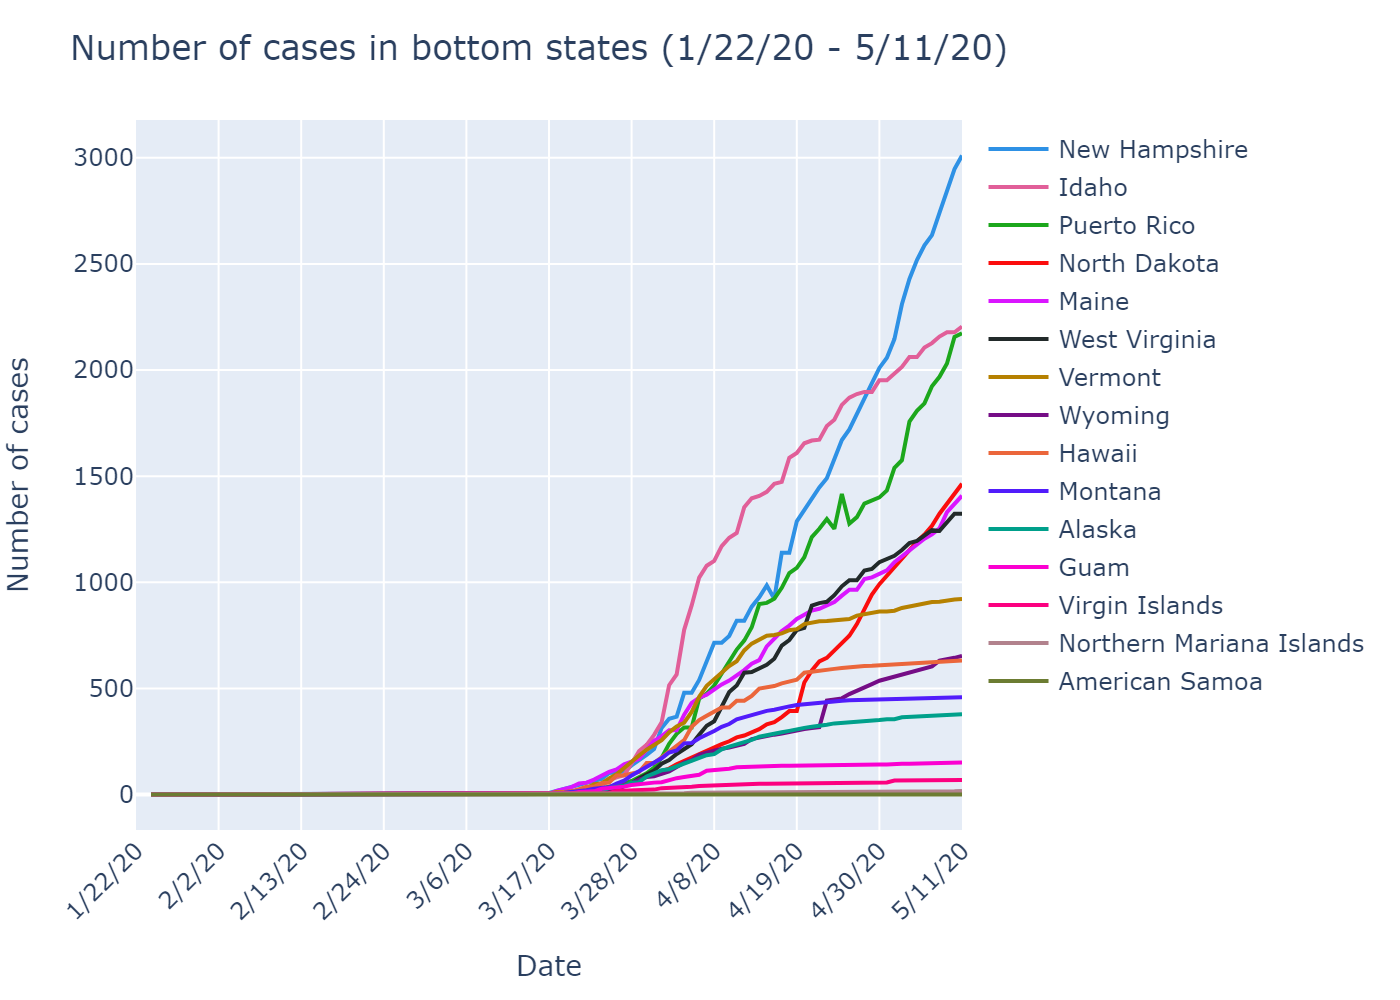

In [150]:
# Now let's look at the number of case across time
bottom_state.sort_values(by=[date_string[-1]], ascending=False, inplace=True)
name_top_state = bottom_state['Province_State']
matrix_num_case = bottom_state.drop(columns=['Province_State', 'Lat', 'Long_']).to_numpy()

# Plot the number of cases
fig = go.Figure()
color_values = plotly.colors.qualitative.Dark24
for index, country in enumerate(name_top_state):
    fig.add_trace(go.Scatter(x=date_string, y=matrix_num_case[index, :], name=country,
                             line=dict(color=color_values[index])))
    
margin_size = 60
fig.update_layout(title='Number of cases in bottom states (' + date_string[0] + ' - ' + date_string[-1] + ')',
                   xaxis_title='Date',
                   yaxis_title='Number of cases',
                 margin=dict(l=margin_size, r=margin_size, t=margin_size, b=margin_size), height=500)
fig.update_xaxes(tickangle=-45, nticks=10)

# Interactive plot
# fig.show()

# Static plot (for view on Github)
Image(pio.to_image(fig, format='png', scale=2))

## See the cases on map

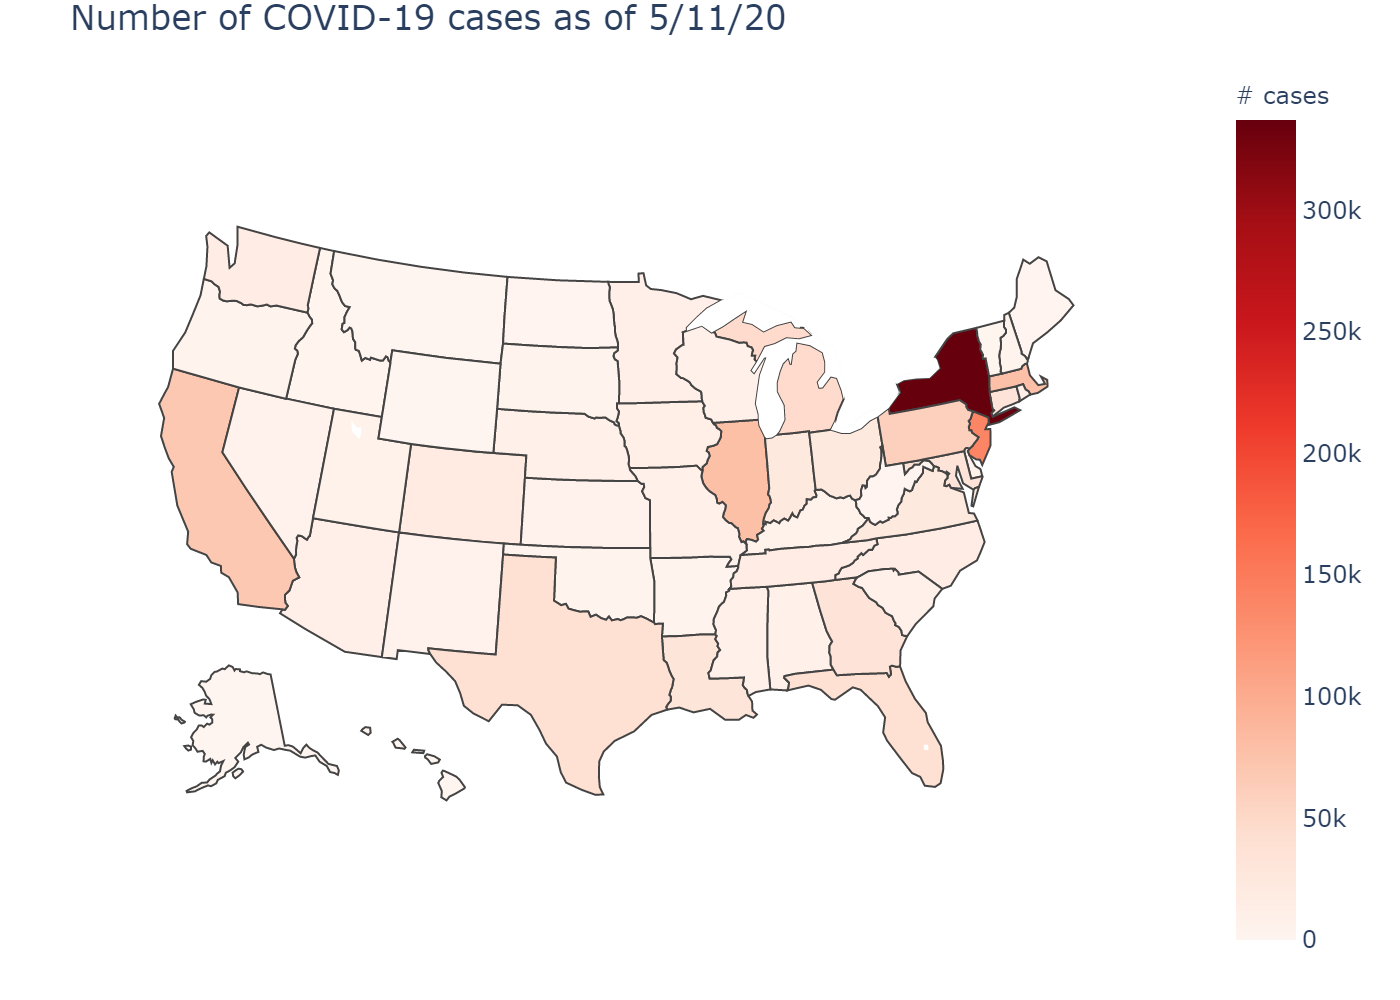

In [154]:
# Use plotly Choropleth built-in map
fig = go.Figure(data=go.Choropleth(
    locations=US_state_case["Code"], # state names
    locationmode = "USA-states", # set the mode to country name
    z = US_state_case[date_string[-1]].astype(float), # Data to be color-coded
    colorscale = 'Reds',
    colorbar_title = "# cases",
))

fig.update_layout(
    title_text = 'Number of COVID-19 cases as of ' + date_string[-1],
    margin=dict(l=20, r=20, t=30, b=20),
    geo_scope='usa', # limite map scope to USA
)

# Interactive plot
# fig.show()

# Static plot (for view on Github)
Image(pio.to_image(fig, format='png', scale=2))